#### The within-vector model
First, import the necessary libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import style

# using the style for the plot
plt.style.use('seaborn-v0_8-bright')

### Model equations

In [4]:
# model parameters
rm, Km, nu, A, rs, Ks, gM = 1.26, 433000, 0.11, 19500, 1.77, 6840000, 0 

paramsWV = np.array([rm, Km, nu, A, rs, Ks, gM])


def WVM(y, t, x): 
    """ Function to solve the WVM as a function of the parameters x"""
    Wm, Ws= y
    rm, Km, nu, A, rs, Ks, gM = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    # Equations
    q = 1e-5
    dWmdt = q*gM + rm*Wm*(1- Wm/Km) - nu*Wm
    dWsdt = (nu*(Wm**2))/(A+(Wm**2)) + rs*Ws*(1- Ws/(Ks+ (1-q)*gM))
    return dWmdt, dWsdt


### Initial conditions and model's solution (without population feedback)

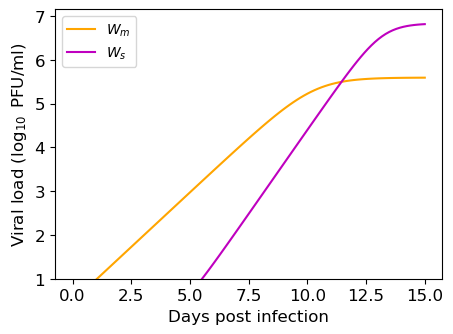

In [6]:
#### --------- Initial conditions
Wm0 = 3
Ws0 = 0


# Initial conditions vector
y0 = Wm0, Ws0

# A grid of time points (in days)
t = np.linspace(0, 15, 100)

# Solution of the model
sol = odeint(WVM, y0, t, args=(paramsWV,))
Wm, Ws = sol.T



#------------------------------- PLOT

fig, ax1 = plt.subplots(figsize=(5,3.5))


#----------------------------------------------------

ax1.plot(t, np.log10(Wm), label=r'$W_m$', color='orange')
ax1.plot(t, np.log10(Ws+1), label=r'$W_s$', color='m')
ax1.set_ylim(bottom=1)
ax1.set_xlabel("Days post infection", fontsize=12)
ax1.set_ylabel(r'Viral load ($\log_{10}$ PFU/ml)', fontsize=12)
ax1.legend(loc='best')
ax1.tick_params(labelsize=12)
#plt.savefig("WV_069.png", bbox_inches = 'tight')
plt.show()

### Model solution and plot for different constant feedback values

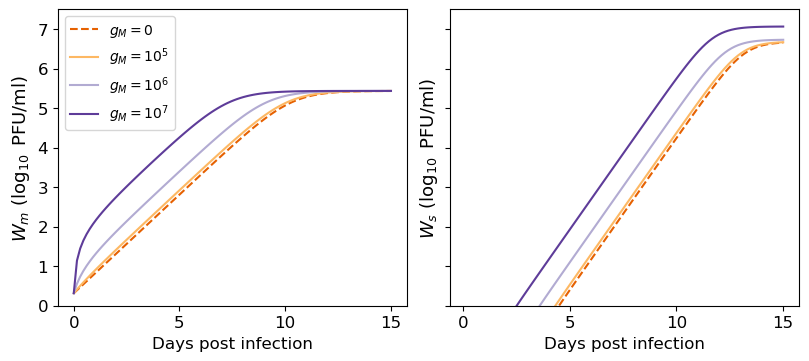

In [7]:
gM1, gM2, gM3 = 1e5, 1e6, 1e7 
paramsWV1 = np.array([rm, Km, nu, A, rs, Ks, gM1])
paramsWV2 = np.array([rm, Km, nu, A, rs, Ks, gM2])
paramsWV3 = np.array([rm, Km, nu, A, rs, Ks, gM3])


sol_n2 = odeint(WVM, y0, t, args=(paramsWV1,))
Wm2, Ws2 = sol_n2.T


sol_n3 = odeint(WVM, y0, t, args=(paramsWV2,))
Wm3, Ws3 = sol_n3.T


sol_n4 = odeint(WVM, y0, t, args=(paramsWV3,))
Wm4, Ws4 = sol_n4.T



fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8,3.5), sharey=True, constrained_layout=True)

#----------------------------------------------------

ax1.plot(t, np.log10(0.69*Wm), '--', label=r'$g_M=0$', color='#e66101')
ax1.plot(t, np.log10(0.69*Wm2), label=r'$g_M=10^5$', color='#fdb863')
ax1.plot(t, np.log10(0.69*Wm3), label=r'$g_M=10^6$', color='#b2abd2')
ax1.plot(t, np.log10(0.69*Wm4), label=r'$g_M=10^7$', color='#5e3c99')
ax1.set_ylim(bottom=0, top=7.5)
ax1.set_xlabel("Days post infection", fontsize=12)
ax1.set_ylabel(r'$W_m$ ($\log_{10}$ PFU/ml)', fontsize=13)
ax1.legend(loc='best')
ax1.tick_params(labelsize=12)

#----------------------------------------------------

ax2.plot(t[1:], np.log10(0.69*Ws[1:]), '--', label=r'$g_M=0$', color='#e66101')
ax2.plot(t[1:], np.log10(0.69*Ws2[1:]), label=r'$g_M=10^5$', color='#fdb863')
ax2.plot(t[1:], np.log10(0.69*Ws3[1:]), label=r'$g_M=10^6$', color='#b2abd2')
ax2.plot(t[1:], np.log10(0.69*Ws4[1:]), label=r'$g_M=10^7$', color='#5e3c99')
ax2.set_ylim(bottom=0)
ax2.set_xlabel("Days post infection", fontsize=12)
ax2.set_ylabel(r'$W_s$ ($\log_{10}$ PFU/ml)', fontsize=13)
#ax2.legend(loc='best')
ax2.tick_params(labelsize=12)

plt.show()

### Equilibrium values and sensitibity analysis

Here, we want to investigate the sensitivity of the equilibrium value of the virus at salivary glands to the parameter values. 

For this, we will use Sobol's sensitivity method.

In [10]:
from SALib.sample.sobol import sample
from SALib.analyze.sobol import analyze

First, define the quantity of interest i.e. $W_s^{*}$ in terms of the parameters.

In [11]:
def Ws_noG(x):
    """ x = model parameters that will vary in the sensitivity analysis
    returns: value of Ws at the equilibrium for uncoupled model"""
    rm, Km, nu, A, rs, Ks = x[0], x[1], x[2], x[3], x[4], x[5]

    Wm = Km*(1-nu/rm)
    
    term1 = nu*(Wm**2)/(A + Wm**2)
    root = np.sqrt(rs**2 + 4*rs*term1/Ks)

    term2 = (Ks/rs)*root
    Ws = 0.5*(Ks + term2)
    
    return Ws

Next, we compute Sobol's indices

In [12]:
#-define a function to evaluate the values of the parameters
     
def evaluate(values):
    Y = np.zeros([values.shape[0]])
    for i, X in enumerate(values):
        Y[i] = Ws_noG(X)
    return Y




    
problem = {
'num_vars': 6,  # number of parameters 
'names': np.array(['rm', 'Km', 'nu','A','rs', 'Ks']), 
'bounds': [[rm/2, rm + (rm/2)],[Km/2, Km+(Km/2)],[nu/2, nu + nu/2],[A/2, A + A/2],[rs/2, rs + rs/2], [Ks/2, Ks + (Ks/2)]]
}



# ------------Generate samples

number_of_samples = 2**14 

param_values = sample(problem, number_of_samples, calc_second_order=True)


# ------------Run model 
Y = evaluate(param_values)



# ------------Perform analysis
Si = analyze(problem, Y, print_to_console=False)


Plot for the indices

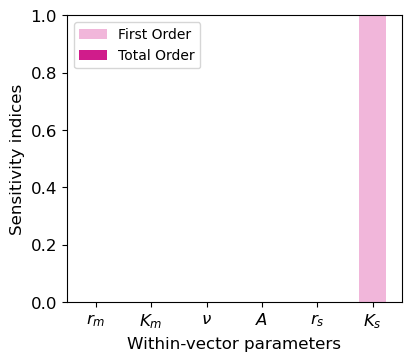

In [13]:
fig, ax1 = plt.subplots(figsize=(4,3.5), ncols=1, nrows=1, sharex=False, sharey=False, constrained_layout=True)

ind = np.arange(len(Si['S1']))   # the x locations for the groups
width = 0.5


p1 = ax1.bar(ind, Si['S1'], width, align='center', color='#f1b6da')
p2 = ax1.bar(ind, Si['ST']-Si['S1'], width, align='center', bottom=Si['S1'], color='#d01c8b')


ax1.set_ylabel('Sensitivity indices', fontsize=12)
ax1.set_xticks(ind)
ax1.set_xticklabels((r'$r_m$', r'$K_m$', r'$\nu$', r'$A$', r'$r_s$', r'$K_s$'), fontsize=12)
ax1.set_xlabel("Within-vector parameters", fontsize=12)
ax1.legend((p1[0], p2[0]), ('First Order', 'Total Order'))
ax1.tick_params(labelsize=12)


plt.show()